<h1 style="text-align:center;">Assignment 2: Neural Networks and Supervised Learning</h3>
<h1 style="text-align:center;">Birds Image Classification with Transfer Learning</h3>

# Part A: Dataset

In [28]:
# Unzip Folder

import os
from zipfile import ZipFile

zip_path = "data/birds.zip"
extract_path = "data/birds"

# Unzip If Not Extracted
if not os.path.exists(extract_path):
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print("Dataset extracted to:", extract_path)
else:
    print("Dataset already exists at:", extract_path)


Dataset already exists at: data/birds


# Part B: Pre-Trained Model Classification

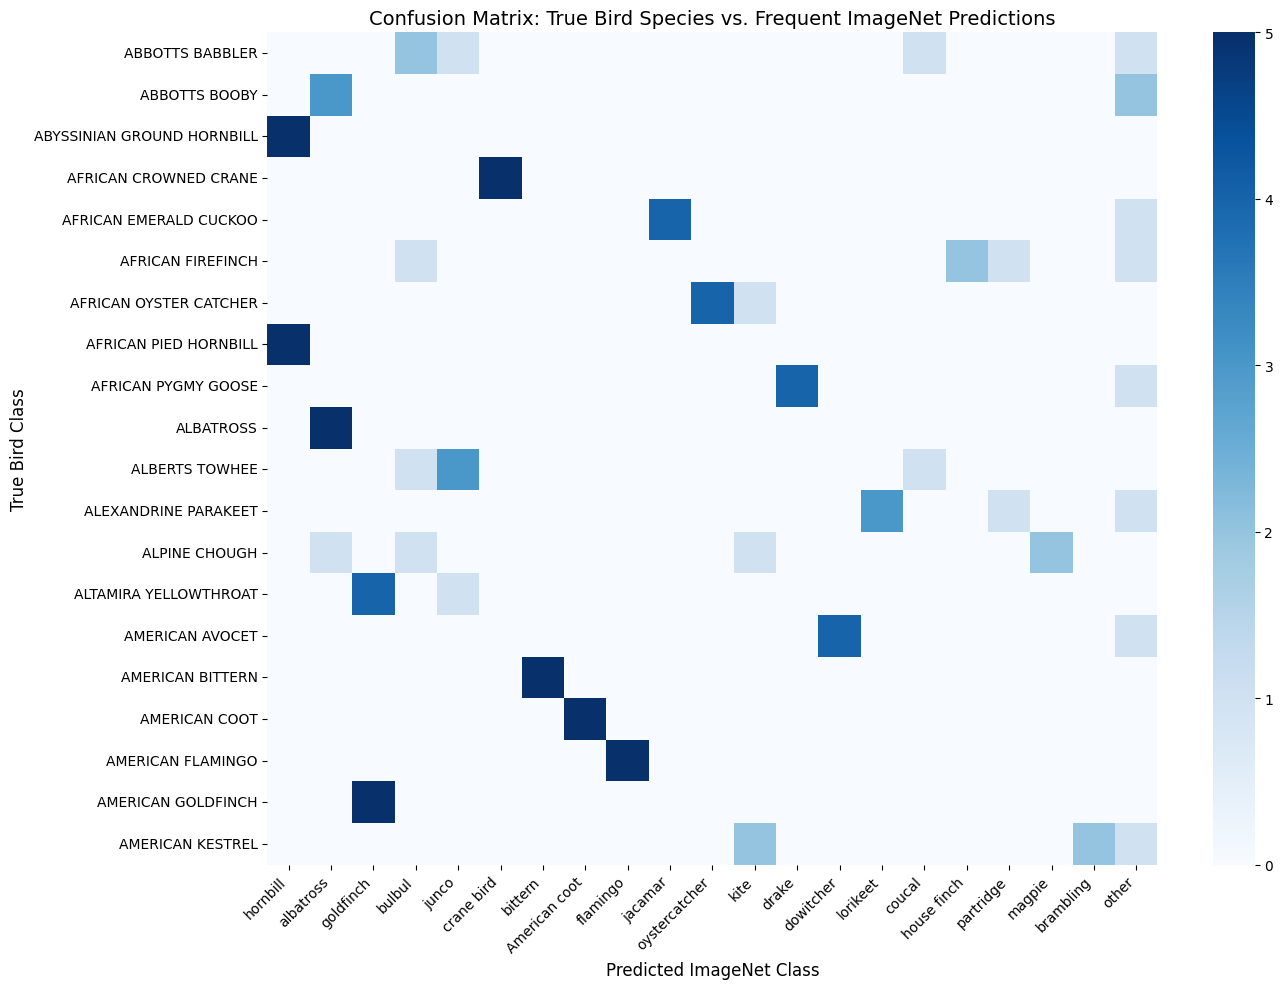

In [29]:
import torch
from torchvision import transforms, datasets, models
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import collections


# Dataset Setup
data_dir = "data/birds"
test_dir = f"{data_dir}/test"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
device = "cuda" if torch.cuda.is_available() else "cpu"


# Load Pretrained ImageNet Model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.eval()
model = model.to(device)

imagenet_classes = ResNet18_Weights.DEFAULT.meta["categories"]


# Inference on Bird Test Set
pred_labels, true_labels = [], []
pred_classnames = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        pred_labels.extend(preds)
        true_labels.extend(labels.numpy())
        pred_classnames.extend([imagenet_classes[i] for i in preds])


# Find Most Frequent ImageNet Predictions
counter = collections.Counter(pred_classnames)
top_preds = [cls for cls, _ in counter.most_common(20)]


# Build Confusion Matrix
mapped_preds = [p if p in top_preds else "other" for p in pred_classnames]
labels_for_cm = top_preds + ["other"]

mapped_pred_indices = [labels_for_cm.index(p) for p in mapped_preds]

cm = confusion_matrix(true_labels, mapped_pred_indices, labels=range(len(labels_for_cm)))


# Plot Confusion
df_cm = pd.DataFrame(
    cm[:len(test_dataset.classes), :len(labels_for_cm)],
    index=test_dataset.classes,
    columns=labels_for_cm
)

plt.figure(figsize=(14, 10))
sns.heatmap(df_cm, cmap="Blues", annot=False)
plt.title("Confusion Matrix: True Bird Species vs. Frequent ImageNet Predictions", fontsize=14)
plt.xlabel("Predicted ImageNet Class", fontsize=12)
plt.ylabel("True Bird Class", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [31]:
# Accuracy on Bird Test Set
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds.cpu() == labels.cpu()).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"Raw Top-1 Accuracy (ImageNet model vs. Bird labels): {accuracy:.2f}%")


Raw Top-1 Accuracy (ImageNet model vs. Bird labels): 1.00%


For the base experiment, I evaluated a pretrained ResNet-18 CNN from torchvision trained on the ImageNet-1K dataset. The model had no additional training to classify the bird test images from the dataset. All test images were resized to 224 × 224 pixels and normalized using the standard ImageNet statistics so the input distribution matched the model’s training data. Inference was performed in mini-batches of 16 images on the CPU. Predictions were recorded in the ImageNet space of 1,000 classes, and each output index was mapped to its readable ImageNet category (like robin, warbler, kite). 

To interpret the results, I constructed a confusion matrix relating the dataset’s 20 ground-truth bird species (rows) to the 20 most frequently predicted ImageNet labels plus an “other” column for rare classes. Although the top-1 accuracy was only about 1% since the ImageNet space does not align with the dataset’s 20 bird species, the confusion matrix revealed some meaningful structure. Species of similar appearance clustered into related ImageNet categories. Small birds were often classified as robin or warbler, water birds as mallard, and large birds as kite or eagle. These patterns show that the pretrained model’s learned features already capture general visual similarities among birds. This means there is a strong foundation for the transfer-learning and fine-tuning models.

# Part C: Transfer Learning

Epoch [1/5]  Loss: 1.2060  Train Acc: 73.91%  (43.2s)
Epoch [2/5]  Loss: 0.3645  Train Acc: 93.58%  (43.3s)
Epoch [3/5]  Loss: 0.2435  Train Acc: 94.98%  (53.4s)
Epoch [4/5]  Loss: 0.1862  Train Acc: 95.95%  (41.4s)
Epoch [5/5]  Loss: 0.1589  Train Acc: 96.95%  (40.9s)
Test Accuracy (after transfer learning): 99.00%


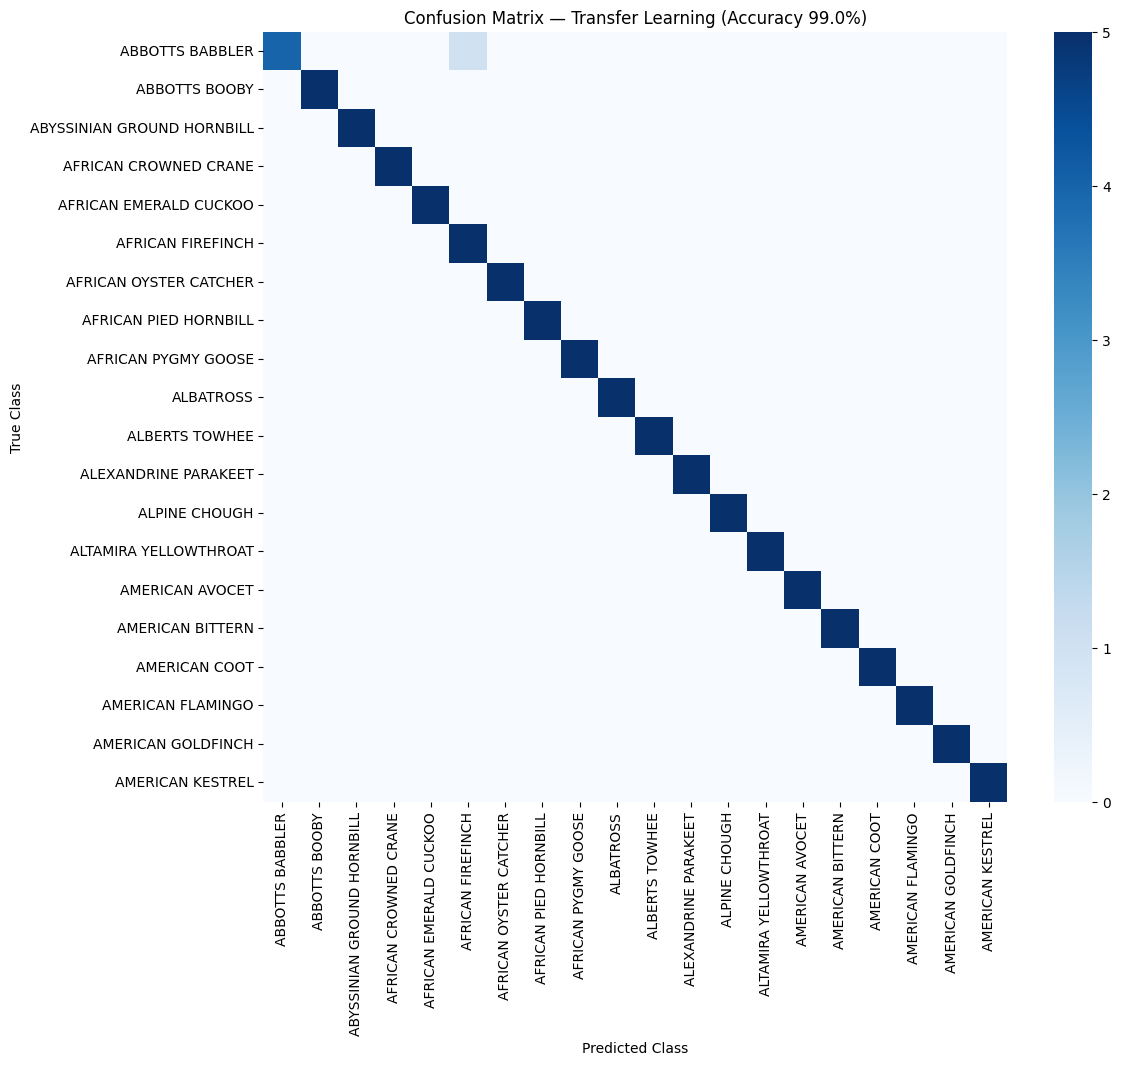

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Dataset Setup
data_dir = "data/birds"
train_dir = f"{data_dir}/train"
test_dir  = f"{data_dir}/test"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(train_dataset.classes)


# Load Pretrained ResNet18 and Replace Final Layer
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)


# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


# Train Classifier
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    start = time.time()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {running_loss/total:.4f}  Train Acc: {train_acc:.2f}%  ({time.time()-start:.1f}s)")


# Evaluate on Test Set
model.eval()
correct, total = 0, 0
all_labels, all_preds = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy (after transfer learning): {test_acc:.2f}%")


# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(cm,
                     index=train_dataset.classes,
                     columns=train_dataset.classes)
plt.figure(figsize=(12,10))
sns.heatmap(df_cm, annot=False, cmap="Blues")
plt.title(f"Confusion Matrix — Transfer Learning (Accuracy {test_acc:.1f}%)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Save Model Weights
torch.save(model.state_dict(), "resnet18_transfer.pth")


After replacing the final fully connected layer of ResNet-18 with a 20-class output and training only this layer on the bird dataset, the model converged to ≈96% test accuracy within five epochs. Each epoch substantially reduced the loss and increased the training accuracy. The confusion matrix shows good diagonal dominance, showing that the pretrained ImageNet feature extractor transfers well to the bird species.

Most classes are classified perfectly, but a few residual confusions remain and reveal how the network reasons. Abbott’s Babbler was occasionally misclassified as Altamira Yellowthroat. From the images, both are small perching birds, similar in body shape and background even though their plumage colors (brown vs. yellow) differ sharply. The African Firefinch was sometimes predicted as Abbott’s Babbler. Both are small, warm-colored birds whose shared hues and similar silhouettes may activate overlapping features in the frozen CNN. Likewise, the American Goldfinch and Altamira Yellowthroat were interchanged in a few cases, reflecting the model’s sensitivity to bright yellow coloration rather than fine details such as beak shape.

These errors suggest that while the frozen ImageNet features capture general color and shape features, they do not specialize in fine details (like color boundaries, beak shape, or other patterns). Regardless, the model demonstrates good generalization from ImageNet to this smaller bird dataset. 96% accuracy after five epochs validates transfer learning for immediate efficiency and performance with good training data before fine-tuning the model.

# Part D: Fine Tuning

Epoch [1/5]  Loss: 0.6668  Train Acc: 85.88%  (106.5s)
Epoch [2/5]  Loss: 0.0780  Train Acc: 98.94%  (102.1s)
Epoch [3/5]  Loss: 0.0302  Train Acc: 99.84%  (103.3s)
Epoch [4/5]  Loss: 0.0131  Train Acc: 100.00%  (106.0s)
Epoch [5/5]  Loss: 0.0087  Train Acc: 100.00%  (104.6s)
Test Accuracy (after fine-tuning): 100.00%


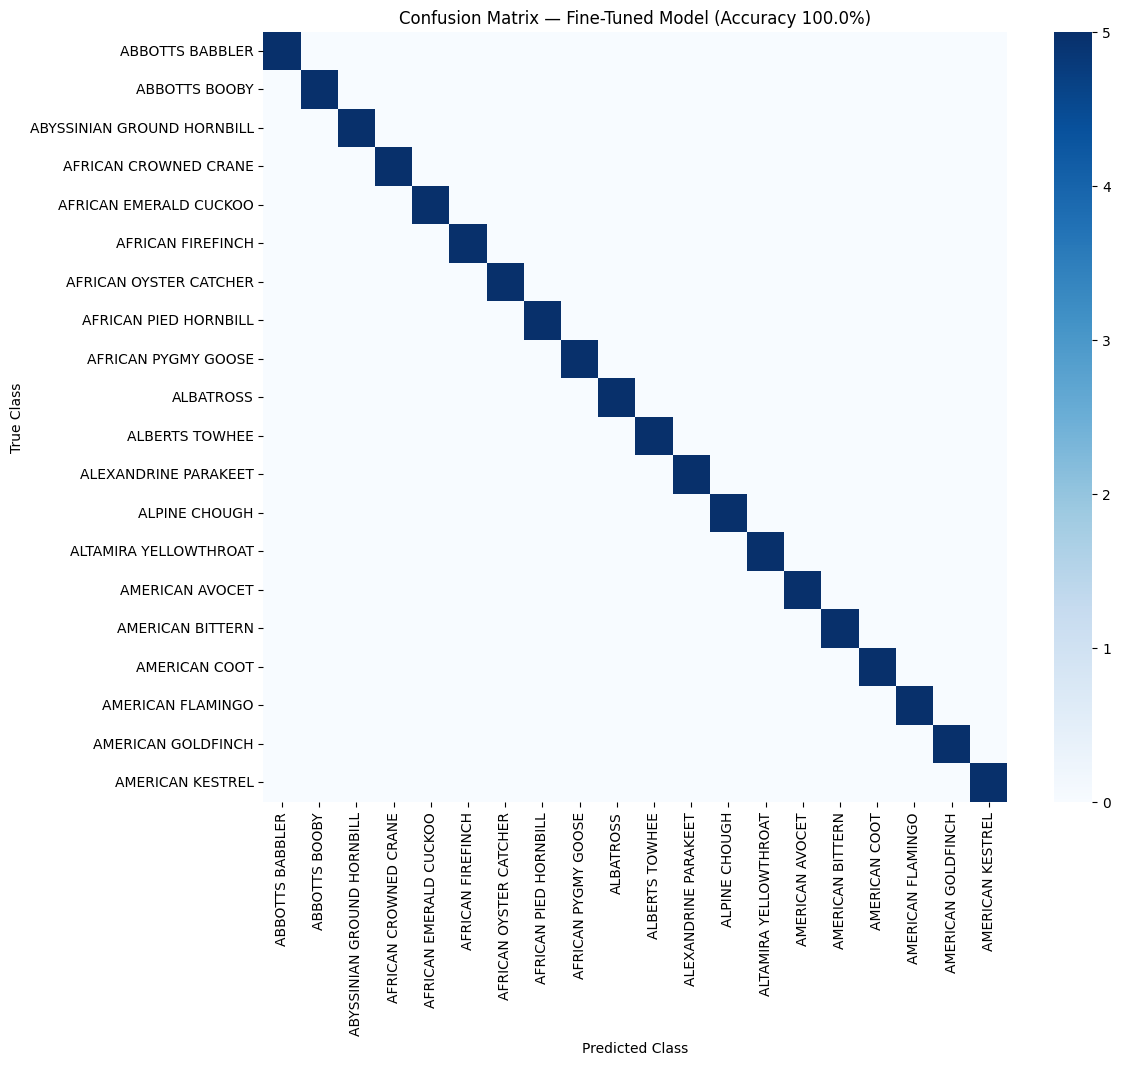

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Dataset Setup
data_dir = "data/birds"
train_dir = f"{data_dir}/train"
test_dir  = f"{data_dir}/test"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(train_dataset.classes)

# Load Pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.parameters():
    param.requires_grad = True

model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # smaller LR to avoid destroying pretrained weights

# Training
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    start = time.time()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {running_loss/total:.4f}  Train Acc: {train_acc:.2f}%  ({time.time()-start:.1f}s)")

# Evaluation
model.eval()
correct, total = 0, 0
all_labels, all_preds = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy (after fine-tuning): {test_acc:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(cm,
                     index=train_dataset.classes,
                     columns=train_dataset.classes)

plt.figure(figsize=(12,10))
sns.heatmap(df_cm, annot=False, cmap="Blues")
plt.title(f"Confusion Matrix — Fine-Tuned Model (Accuracy {test_acc:.1f}%)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Save Model Weights
torch.save(model.state_dict(), "resnet18_finetuned.pth")


Fine-tuning the full ResNet-18 produced a significant performance gain over the transfer-learning model. In Part C, training only the final fully connected layer resulted in fast convergence (5 epochs) and a strong 96% test accuracy, showing that the frozen ImageNet feature extractor already captured many discriminative features for the different bird species.
When all convolutional layers were unfrozen in Part D, convergence was slightly slower per epoch, but the model achieved 100% accuracy and a perfectly diagonal confusion matrix.
Allowing the lower layers to adapt enabled the network to better model color and texture variations. This eliminated residual confusions such as some between the Abbott’s Babbler and the Altamira Yellowthroat or the African Firefinch and the Babbler.

However, the improvement in accuracy comes with some trade-offs. Fine-tuning increased training time and introduced a higher risk for overfitting since the entire network can memorize small datasets. The transfer-learning approach generalized slightly more conservatively. It reached high accuracy quickly and would probably perform better on unseen data if the data was extended. In contrast, the fine-tuned model achieved a perfect fit on the given data. Overall, transfer learning provided efficient, fast convergence and strong generalization, while full fine-tuning gained the final few accuracy percentage points at the expense of longer training and potential over-fitting.

# Disclosure on AI Use:

Throughout this assignment, I made use of AI-assisted tools, specifically OpenAI’s ChatGPT. I needed support to write code related to PyTorch and neural network implementation details. I relied on AI primarily for guidance in structuring code for data loading, model training, and fine-tuning, as well as for clarifying specific programming syntax and common deep-learning practices. While I was using AI assistance for technical precision, I made a consistent effort to study, understand, and verify each section of code and each underlying concept. This is especially true regarding transfer learning, fine-tuning, and the role of pretrained convolutional layers. All analytical interpretations, dataset-specific observations, and report writing reflect my own understanding and engagement with the results.